# Machine Learning Engineer Nanodegree - Capstone Project
## PART 3: Word2vec

**Author:** Giacomo Sarchioni

In [139]:
# Module imports
import pickle as pkl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nltk
import re
from tqdm import tqdm
from gensim.models import Word2Vec

random_seed = 42

## Data import

In [9]:
# Get indexes
with open('split_indexes/indexes.pkl', 'rb') as f:
    indexes = pkl.load(f)

In [32]:
# Get sentiment reviews
with open('reviews/sentiment_reviews/sentiment.pkl', 'rb') as f:
    sentiment_reviews = pkl.load(f)
    
# Get neutral reviews
with open('reviews/neutral_reviews/neutral.pkl', 'rb') as f:
    neutral_reviews = pkl.load(f)

In [44]:
# Get sentiment non_test sentiment reviews parser_one text
non_test_parser_zero_reviews = sentiment_reviews.parser_zero.values[indexes['non_test']]

# Get neutral reviews parser_one text
parser_zero_neutral_reviews = neutral_reviews.parser_zero.values

In [45]:
# Define reviews for word2vec model
reviews_for_word2vec = np.append(non_test_parser_zero_reviews, parser_zero_neutral_reviews)

In [46]:
# Randomly shuffle reviews
np.random.shuffle(reviews_for_word2vec)

## Punkt tokenizer

In [47]:
# Download punctuation tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

The punctuation tokeniser is capable of splitting a string paragraph into a list of sentences based on punctuation. I have added an example below.

In [48]:
example = "The product was delivered on time. I have used it for a few days and I definitely recommend it."
tokenizer.tokenize(example)

['The product was delivered on time.',
 'I have used it for a few days and I definitely recommend it.']

I have used `parser_zero` data because I need to keep punctuation (i.e. non-letter characters) in order to split my reviews into sentences. Once this is done, however, I would revemo non-letter characters. That is why I define a simple `keep_letters_only` function.

In [62]:
def keep_letters_only(sentence):
    
    """
    
        Keep only letters in a given string.
        
        Args:
            - sentence: string
            
        Returns:
            - sentence: list
    
    """
    
    # Keep letters only
    sentence = re.sub('[^a-zA-Z]', " ", sentence)
    
    # Return list of words
    return sentence.split()

In [68]:
# Apply tokeniser to all the reviews
train_sentences = []
for review in tqdm(reviews_for_word2vec):
    for tokenized_r in tokenizer.tokenize(review):
        
        # Keep letters only
        r_letters_only = keep_letters_only(tokenized_r)
        if len(r_letters_only) > 0:
            train_sentences.append(r_letters_only)

100%|██████████| 357195/357195 [00:57<00:00, 6253.50it/s]


In [69]:
# Print first original review
reviews_for_word2vec[0]

'these keep my dogs busy for hours at a time...they love it!  easy to use and it seems to clean their teeth too.'

In [70]:
# Print sentences into which the first review has been split
print(train_sentences[0])
print(train_sentences[1])

['these', 'keep', 'my', 'dogs', 'busy', 'for', 'hours', 'at', 'a', 'time', 'they', 'love', 'it']
['easy', 'to', 'use', 'and', 'it', 'seems', 'to', 'clean', 'their', 'teeth', 'too']


In [71]:
# Save the reviews for word2vec training
with open('reviews/word2vec_reviews/reviews_for_word2vec.pkl', 'wb') as f:
    pkl.dump(train_sentences, f)

## `gensim` word2vec

In [3]:
# Load reviews for word2vec training
with open('reviews/word2vec_reviews/reviews_for_word2vec.pkl', 'rb') as f:
    train_sentences = pkl.load(f)

In [76]:
# Train default cbow model
default_cbow = Word2Vec(train_sentences, seed=random_seed, size=300, workers=16)

In [80]:
# Train default sgram model
default_sgram = Word2Vec(train_sentences, seed=random_seed, size=300, workers=16, sg=1)

In [81]:
# Print most similar to good using cbow model
default_cbow.wv.most_similar(['good'], topn=5)

[('great', 0.7333831787109375),
 ('decent', 0.6977159380912781),
 ('fantastic', 0.6646863222122192),
 ('terrific', 0.6386393904685974),
 ('bad', 0.6170471906661987)]

In [36]:
# Print most similar to good using sgram model
default_sgram.wv.most_similar(['good'], topn=5)

[('goood', 0.6669744253158569),
 ('great', 0.6536601781845093),
 ('decent', 0.6179765462875366),
 ('gooood', 0.6065623760223389),
 ('agreat', 0.5981117486953735)]

In [87]:
# Save Word2vec default cbow model
default_cbow.init_sims(replace=True)
default_cbow.save('word2vec_models/default_cbow_word2vec.hdf5')

# Save Word2vec default skip-gram model
default_sgram.init_sims(replace=True)
default_sgram.save('word2vec_models/default_sgram_word2vec.hdf5')

In [5]:
# Load Word2vec models
default_cbow = Word2Vec.load('word2vec_models/default_cbow_word2vec.hdf5')
default_sgram = Word2Vec.load('word2vec_models/default_sgram_word2vec.hdf5')

#### Cosine similarities for opposite words

In [117]:
# List of opposites
opposites = [('good', 'bad'),
             ('awesome', 'terrible'),
             ('delicious', 'disgusting'), 
             ('tasty', 'unsavory'), 
             ('worthy', 'unworthy')]

# labels
labels = [c[0] + "-" + c[1] for c in opposites]

In [118]:
# Evaluate similarities
cbow_similarities = []
sgram_similarities = []

# Loop through
for c in opposites:
    cbow_similarities.append(default_cbow.wv.similarity(c[0], c[1]))
    sgram_similarities.append(default_sgram.wv.similarity(c[0], c[1]))

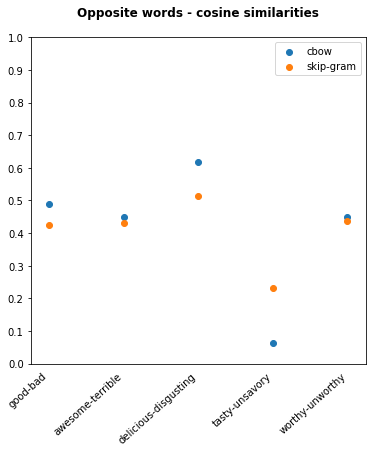

In [137]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.scatter(labels, cbow_similarities, label='cbow')
ax.scatter(labels, sgram_similarities, label='skip-gram')
ax.axes.set_ylim(0.,1.)
ax.axes.set_yticks(list(np.arange(0., 1.1, 0.1)))
ax.axes.set_xticklabels(labels=labels, rotation=42, va='top', ha='right')
ax.axes.xaxis.set_ticks_position('none')
ax.legend()
plt.title('Opposite words - cosine similarities\n', weight='bold');